In [69]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [70]:
class Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)
        
        # Initialize biases and weights
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)

    def forward(self, x):
        y1 = torch.tanh(self.linear1(x))
        y2 = torch.tanh(self.linear2(y1))
        y3 = torch.tanh(self.linear3(y2))
        y = self.linear4(y3)
        return y

In [71]:
D_in, H, D_out = 1, 200, 1  # Example dimensions, can be modified based on ODE requirements
model = MultiLayerNet(D_in, H, D_out)


In [72]:
def energy_functional(x, y, dy_dx):
    # Defines the energy functionalor aka the ODE/PDE based on the problem requirements. 
    # Here you can modify the functino yourself to match the energy function of your specific problem.
    # Like as an examle, if it's elasticity, you can use function of strain energy
    # Here, I defined a dummy function for simple demonstration.
    return 0.5 * (dy_dx ** 2) - 0.5 *  (y ** 2)  # Example: strain energy with linear potential that I found online.

In [73]:
x_range = (0.0, 10)  # Domain for the ODE
initial_conditions = [
    {'type': 'y', 'value': 1.0, 'x': 0.0},    # y(0) = 1
    {'type': 'y\'', 'value': 0.0, 'x': 0.0},  # y'(0) = 0
]
learning_rate = 0.001
num_epochs = 1000

In [74]:
def compute_energy_integral(net, x_range, num_points=1000):
    """Compute the integral of the energy functional over the specified x range."""
    x_min, x_max = x_range
    x = torch.linspace(x_min, x_max, num_points).view(-1, 1)
    x.requires_grad = True  
    
    y_pred = net(x)
    dy_dx_pred = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
    
    energy_vals = energy_functional(x, y_pred, dy_dx_pred)
    
    integral = torch.mean(energy_vals) * (x_max - x_min)
    return integral ** 2

In [75]:
def apply_initial_conditions(net, initial_conditions):
    ivp_residuals = []
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)
        y_ivp = net(x_ivp)
        
        if ivp['type'] == 'y':
            ivp_residual = y_ivp - ivp['value']
        elif ivp['type'] == 'y\'':
            dy_dx_ivp = torch.autograd.grad(y_ivp, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]
            ivp_residual = dy_dx_ivp - ivp['value']
        
        ivp_residuals.append(ivp_residual ** 2)
    
    return torch.sum(torch.stack([ivp**2 for ivp in ivp_residuals]))

In [76]:
def train(net, optimizer, x_range, initial_conditions, num_epochs):
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Compute the energy integral
        energy_integral = compute_energy_integral(net, x_range)

        # Apply initial condition residuals as constraints
        ivp_residual = apply_initial_conditions(net, initial_conditions)

        # Total loss: Energy integral + initial condition penalty
        loss = energy_integral + ivp_residual
        loss.backward()
        optimizer.step()
        # scheduler.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [77]:
net = Network(D_in, H, D_out)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

# Initialize the learning rate scheduler
# step_size = 100  # Number of epochs after which to decay the learning rate
# gamma = 0.1      # Multiplicative factor of learning rate decay
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-6)





In [78]:
train(net, optimizer, x_range, initial_conditions, num_epochs)

Epoch 0, Loss: 2.1762638092041016
Epoch 100, Loss: 0.1354275643825531
Epoch 200, Loss: 0.04226268455386162
Epoch 300, Loss: 0.021155890077352524
Epoch 400, Loss: 0.017522424459457397
Epoch 500, Loss: 0.016619665548205376
Epoch 600, Loss: 0.015912465751171112
Epoch 700, Loss: 0.015143992379307747
Epoch 800, Loss: 0.014291083440184593
Epoch 900, Loss: 0.013348530977964401


In [79]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    y_pred = net(x_tensor).detach().numpy()

    plt.plot(x_values, y_pred, label="DEM Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the Harmonic Oscillator via DEM")
    plt.legend()
    plt.grid(True)
    plt.show()

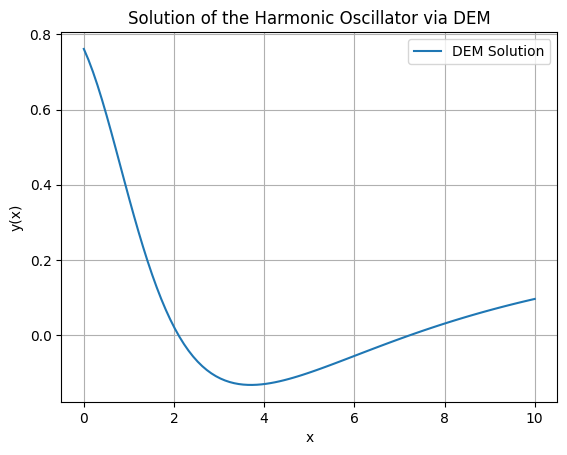

In [80]:
visualize_solution(net, x_range)